# Making a random Polygon

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PyEscape.escape_plan import escape
from PyEscape.escape_points import random_points_on_hull
from PyEscape.escape_polygonhelper import make_hull_and_scale
from tqdm import tqdm

In [2]:
D = 400
v = 1
a = 0.1
n_pores = 1
pts = np.random.random((10,3))
hull, pts = make_hull_and_scale(pts)
pores = random_points_on_hull(hull)

N = 10
results = []
for i in tqdm(range(N)):
    results.append(escape(D, v, a, pores, dt=1e-6, hull=hull, shape='polygon'))

100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


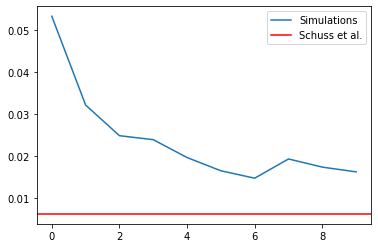

In [3]:
mov_avg = np.cumsum(results)/(1+np.arange(len(results)))

plt.figure()
plt.plot(mov_avg, label='Simulations')
plt.axhline(0.00625, label='Schuss et al.', c='r')
plt.legend()

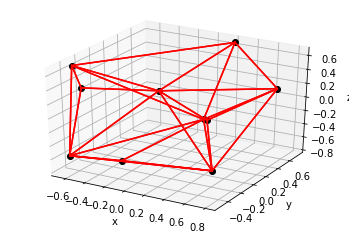

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

plt.show()

# Converting Polygon to Ellipsoid

In [5]:
from tqdm import tqdm
from PyEscape.escape_polygonhelper import make_hull_and_scale
from PyEscape.escape_polygonhelper import isolate_points_from_segmented_imagestack
from PyEscape.escape_polygonhelper import fit_polygon_to_ellipsoid
from PyEscape.escape_points import random_points_on_hull, random_points_on_ellipsoid
from PyEscape.escape_plan import escape
from skimage import io
import numpy as np
import multiprocessing
from sys import argv
from os import cpu_count

img_loc = "/Users/nathan/PHD/Modelling/EscapeLeafCellsMultipleEscapes/data/Leaf segmentation.tif"
leaf_stack = io.imread(img_loc)

unique_cell_ids = np.genfromtxt("/Users/nathan/PHD/Modelling/EscapeLeafCellsMultipleEscapes/data/cells_idx.csv").astype('int')[1:]
idx=70

pts = isolate_points_from_segmented_imagestack(leaf_stack, unique_cell_ids[idx], .2768, .2768, .9766)
hull, pts = make_hull_and_scale(pts)


ModuleNotFoundError: No module named 'skimage'

In [13]:
def correction_SA(a,b=1,c=1, vol=1):
    def vol_Ellip(a, b, c): return 4/3*np.pi*a*b*c
    def SA_Ellip(a,b,c): return 4*np.pi*( ((a*b)**1.6 + (a*c)**1.6 + (b*c)**1.6)/3  )**(1/1.6)
    volN = vol_Ellip(a, b, c)
    cbrt_diff = vol/np.cbrt(volN)
    a, b, c = np.array([a, b, c]) * cbrt_diff
    Lin = min([a,b,c])
    Lout = max([a,b,c])
    Lin = SA_Ellip(Lin, Lin, Lin)
    Lout = SA_Ellip(Lout, Lout, Lout)
    return Lout/Lin

In [34]:
ratios = []
abcs = []
for idx, cell in enumerate(unique_cell_ids):
    pts = isolate_points_from_segmented_imagestack(leaf_stack, cell, .2768, .2768, .9766)
    hull, pts = make_hull_and_scale(pts)
    a,b,c = fit_polygon_to_ellipsoid(hull)
    abcs.append([a,b,c])
    ratios.append(correction_SA(a,b,c))
    if idx == 50:
        break

In [32]:
ratios = np.array(ratios)

(array([62., 17.,  8.,  3.,  3.,  3.,  0.,  1.,  1.,  1.]),
 array([  11. ,  207.2,  403.4,  599.6,  795.8,  992. , 1188.2, 1384.4,
        1580.6, 1776.8, 1973. ]),
 <BarContainer object of 10 artists>)

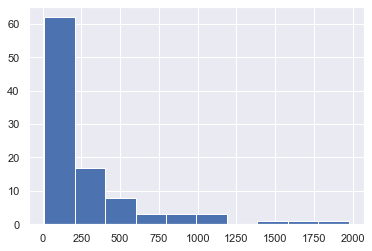

In [33]:
import seaborn as sns

plt.hist(np.around(ratios[ratios<2000]))

In [5]:
from PyEscape.escape_polygonhelper import fit_polygon_to_ellipsoid
from PyEscape.escape_points import random_points_on_ellipsoid



ABC = fit_polygon_to_ellipsoid(hull)
pores = random_points_on_ellipsoid(ABC)

N = 10
results = []
for i in tqdm(range(N)):
    results.append(escape(D, v, a, pores, dt=1e-6, ABC=ABC, shape='ellipsoid'))

100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


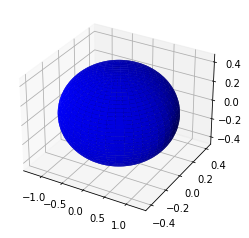

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

phi = np.linspace(0,2*np.pi, 256).reshape(256, 1) # the angle of the projection in the xy-plane
theta = np.linspace(0, np.pi, 256).reshape(-1, 256) # the angle from the polar axis, ie the polar angle
radius = 4

# Transformation formulae for a spherical coordinate system.
x = ABC[0]*np.sin(theta)*np.cos(phi)
y = ABC[1]*np.sin(theta)*np.sin(phi)
z = ABC[2]*np.cos(theta)

fig = plt.figure(figsize=plt.figaspect(1))  # Square figure
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, color='b')


In [7]:
from tqdm import tqdm
from PyEscape.escape_polygonhelper import make_hull_and_scale
from PyEscape.escape_polygonhelper import isolate_points_from_segmented_imagestack
from PyEscape.escape_polygonhelper import fit_polygon_to_ellipsoid
from PyEscape.escape_points import random_points_on_hull, random_points_on_ellipsoid
from PyEscape.escape_plan import escape
from skimage import io
import numpy as np
import multiprocessing
from sys import argv
from os import cpu_count

img_loc = "/Users/nathanhughes/PHD/Modelling/EscapeLeafCellsMultipleEscapes/data/Leaf segmentation.tif"
leaf_stack = io.imread(img_loc)

unique_cell_ids = np.genfromtxt("/Users/nathanhughes/PHD/Modelling/EscapeLeafCellsMultipleEscapes/data/cells_idx.csv").astype('int')[1:]
idx=70

pts = isolate_points_from_segmented_imagestack(leaf_stack, unique_cell_ids[idx], .2768, .2768, .9766)
hull, pts = make_hull_and_scale(pts)

ABC = fit_polygon_to_ellipsoid(hull)
ABC

array([0.26467467, 0.33265048, 2.71150778])

In [8]:
def calc_ratio(img, idx):
    pts = isolate_points_from_segmented_imagestack(img, unique_cell_ids[idx], .2768, .2768, .9766)
    hull, pts = make_hull_and_scale(pts)
    a,b,c = fit_polygon_to_ellipsoid(hull)
    return [a,b,c]
calc_ratio(leaf_stack, idx)

[0.2646746720766011, 0.3326504782977085, 2.7115077795057245]

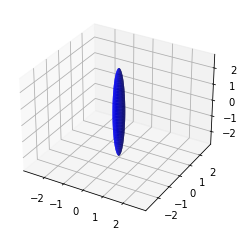

In [9]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=plt.figaspect(1))  # Square figure
ax = fig.add_subplot(111, projection='3d')

phi = np.linspace(0,2*np.pi, 256).reshape(256, 1) # the angle of the projection in the xy-plane
theta = np.linspace(0, np.pi, 256).reshape(-1, 256) # the angle from the polar axis, ie the polar angle
radius = 4

# Transformation formulae for a spherical coordinate system.
X = ABC[0]*np.sin(theta)*np.cos(phi)
Y = ABC[1]*np.sin(theta)*np.sin(phi)
Z = ABC[2]*np.cos(theta)

# Create cubic bounding box to simulate equal aspect ratio
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
# Comment or uncomment following both lines to test the fake bounding box:
for xb, yb, zb in zip(Xb, Yb, Zb):
    ax.plot([xb], [yb], [zb], 'w')


ax.plot_surface(X, Y, Z, color='b', alpha=0.9)

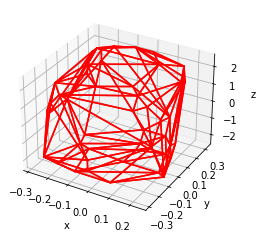

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")


# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

# Create cubic bounding box to simulate equal aspect ratio
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
# Comment or uncomment following both lines to test the fake bounding box:
#for xb, yb, zb in zip(Xb, Yb, Zb):
#    ax.plot([xb], [yb], [zb], 'w')
#ax.plot_surface(X, Y, Z, color='b', alpha=0.5)
plt.show()

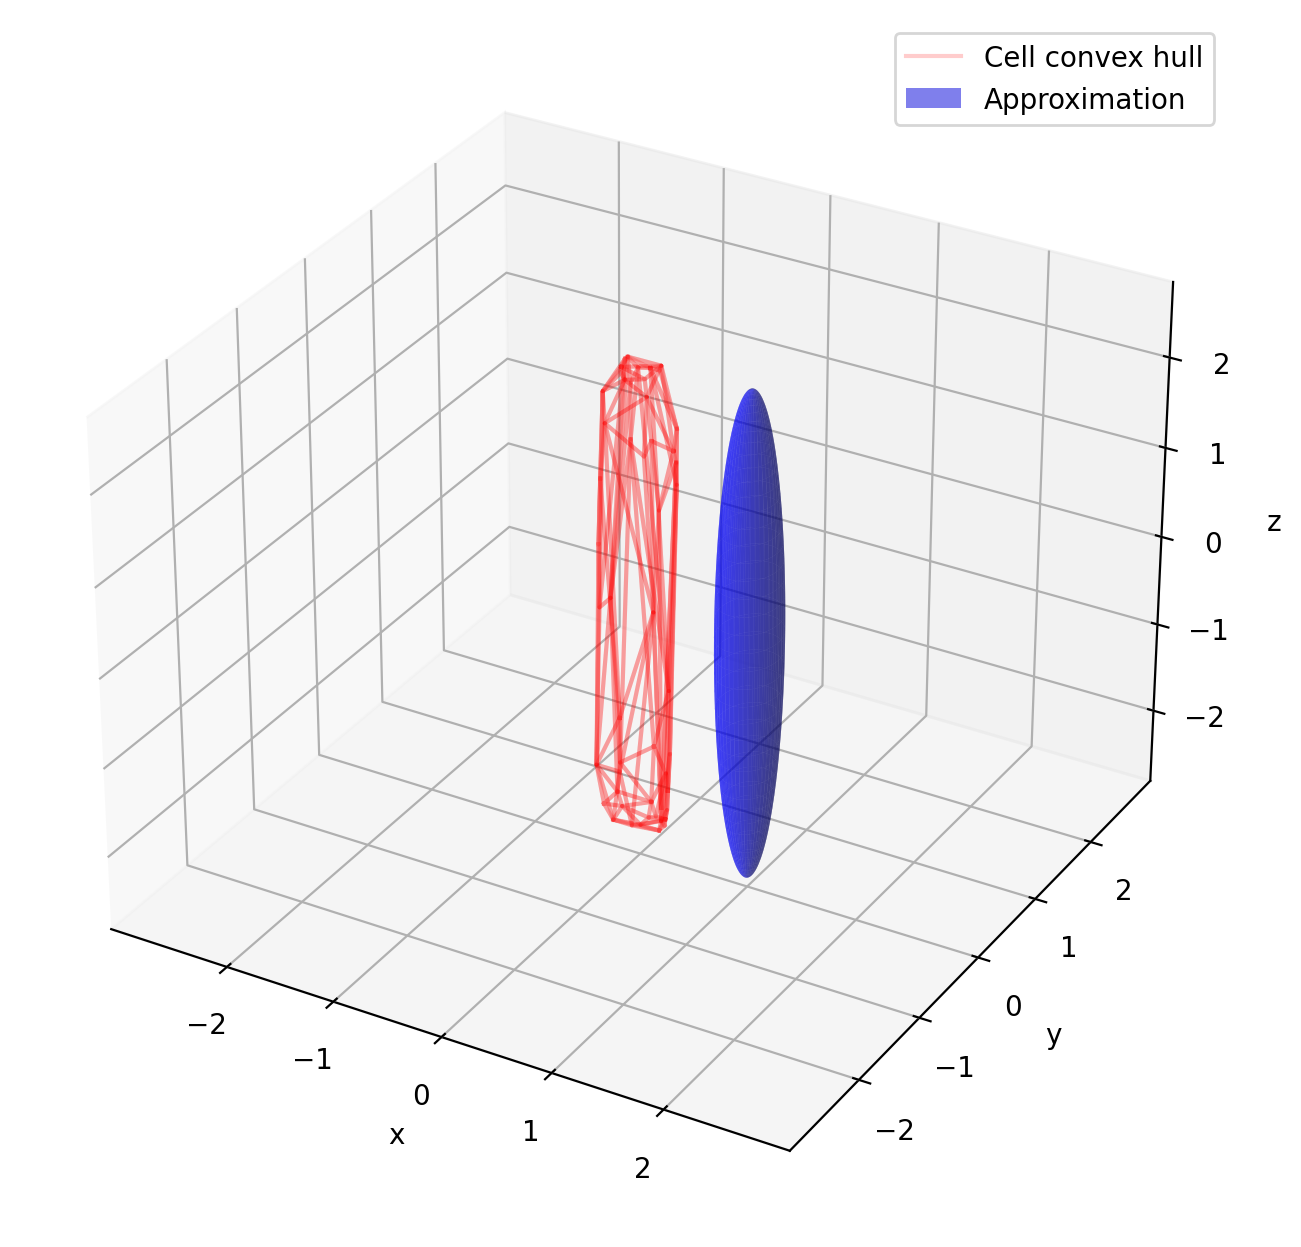

In [17]:
fig = plt.figure( figsize=(8,8), dpi=200)
ax = fig.add_subplot(111, projection="3d")


# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for idx, s in enumerate(hull.simplices):
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r-", alpha=0.2, label=('Cell convex hull' if idx==0 else None) )

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

# Create cubic bounding box to simulate equal aspect ratio
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
# Comment or uncomment following both lines to test the fake bounding box:
for xb, yb, zb in zip(Xb, Yb, Zb):
    ax.plot([xb], [yb], [zb], 'w', alpha=0.3)
    
c3=ax.plot_surface(X+1, Y, Z, color='b', alpha=0.5, label='Approximation')
c3._facecolors2d='b'
c3._edgecolors2d='b'
ax.legend()
fig.savefig("/Users/nathanhughes/PHD/Documents/Progress/2021_04/figures/approxCells.png")

In [ ]:
pts

In [ ]:
import numpy as np
from sympy import Plane, Point3D
import networkx as nx


def simplify(triangles):
    """
    Simplify an iterable of triangles such that adjacent and coplanar triangles form a single face.
    Each triangle is a set of 3 points in 3D space.
    """

    # create a graph in which nodes represent triangles;
    # nodes are connected if the corresponding triangles are adjacent and coplanar
    G = nx.Graph()
    G.add_nodes_from(range(len(triangles)))
    for ii, a in enumerate(triangles):
        for jj, b in enumerate(triangles):
            if (ii < jj): # test relationships only in one way as adjacency and co-planarity are bijective
                if is_adjacent(a, b):
                    if is_coplanar(a, b, np.pi / 180.):
                        G.add_edge(ii,jj)

    # triangles that belong to a connected component can be combined
    components = list(nx.connected_components(G))
    simplified = [set(flatten(triangles[index] for index in component)) for component in components]

    # need to reorder nodes so that patches are plotted correctly
    reordered = [reorder(face) for face in simplified]

    return reordered


def is_adjacent(a, b):
    return len(set(a) & set(b)) == 2 # i.e. triangles share 2 points and hence a side


def is_coplanar(a, b, tolerance_in_radians=0):
    a1, a2, a3 = a
    b1, b2, b3 = b
    plane_a = Plane(Point3D(a1), Point3D(a2), Point3D(a3))
    plane_b = Plane(Point3D(b1), Point3D(b2), Point3D(b3))
    if not tolerance_in_radians: # only accept exact results
        return plane_a.is_coplanar(plane_b)
    else:
        angle = plane_a.angle_between(plane_b).evalf()
        angle %= np.pi # make sure that angle is between 0 and np.pi
        return (angle - tolerance_in_radians <= 0.) or \
            ((np.pi - angle) - tolerance_in_radians <= 0.)


flatten = lambda l: [item for sublist in l for item in sublist]


def reorder(vertices):
    """
    Reorder nodes such that the resulting path corresponds to the "hull" of the set of points.

    Note:
    -----
    Not tested on edge cases, and likely to break.
    Probably only works for convex shapes.

    """
    if len(vertices) <= 3: # just a triangle
        return vertices
    else:
        # take random vertex (here simply the first)
        reordered = [vertices.pop()]
        # get next closest vertex that is not yet reordered
        # repeat until only one vertex remains in original list
        vertices = list(vertices)
        while len(vertices) > 1:
            idx = np.argmin(get_distance(reordered[-1], vertices))
            v = vertices.pop(idx)
            reordered.append(v)
        # add remaining vertex to output
        reordered += vertices
        return reordered


def get_distance(v1, v2):
    v2 = np.array(list(v2))
    difference = v2 - v1
    ssd = np.sum(difference**2, axis=1)
    return np.sqrt(ssd)

In [ ]:
from scipy.spatial import HalfspaceIntersection
from scipy.spatial import ConvexHull
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as a3

w = np.array([1., 1., 1.])
# ∑ᵢ hᵢ wᵢ qᵢ - ∑ᵢ gᵢ wᵢ <= 0 
#  qᵢ - ubᵢ <= 0
# -qᵢ + lbᵢ <= 0 
halfspaces = np.array([
                    [1.*w[0], 1.*w[1], 1.*w[2], -10 ],
                    [ 1.,  0.,  0., -4],
                    [ 0.,  1.,  0., -4],
                    [ 0.,  0.,  1., -4],
                    [-1.,  0.,  0.,  0],
                    [ 0., -1.,  0.,  0],
                    [ 0.,  0., -1.,  0]
                    ])
feasible_point = np.array([0.1, 0.1, 0.1])
hs = HalfspaceIntersection(halfspaces, feasible_point)
verts = hs.intersections
#hull = ConvexHull(verts)
hull, pts = make_hull_and_scale(pts)

simplices = hull.simplices

org_triangles = [verts[s] for s in simplices[:10]]

class Faces():
    def __init__(self,tri, sig_dig=12, method="convexhull"):
        self.method=method
        self.tri = np.around(np.array(tri), sig_dig)
        self.grpinx = list(range(len(tri)))
        norms = np.around([self.norm(s) for s in self.tri], sig_dig)
        _, self.inv = np.unique(norms,return_inverse=True, axis=0)

    def norm(self,sq):
        cr = np.cross(sq[2]-sq[0],sq[1]-sq[0])
        return np.abs(cr/np.linalg.norm(cr))

    def isneighbor(self, tr1,tr2):
        a = np.concatenate((tr1,tr2), axis=0)
        return len(a) == len(np.unique(a, axis=0))+2

    def order(self, v):
        if len(v) <= 3:
            return v
        v = np.unique(v, axis=0)
        n = self.norm(v[:3])
        y = np.cross(n,v[1]-v[0])
        y = y/np.linalg.norm(y)
        c = np.dot(v, np.c_[v[1]-v[0],y])
        if self.method == "convexhull":
            h = ConvexHull(c)
            return v[h.vertices]
        else:
            mean = np.mean(c,axis=0)
            d = c-mean
            s = np.arctan2(d[:,0], d[:,1])
            return v[np.argsort(s)]

    def simplify(self):
        for i, tri1 in enumerate(self.tri):
            for j,tri2 in enumerate(self.tri):
                if j > i: 
                    if self.isneighbor(tri1,tri2) and \
                       self.inv[i]==self.inv[j]:
                        self.grpinx[j] = self.grpinx[i]
        groups = []
        for i in np.unique(self.grpinx):
            u = self.tri[self.grpinx == i]
            u = np.concatenate([d for d in u])
            u = self.order(u)
            groups.append(u)
        return groups


f = Faces(org_triangles)
g = f.simplify()

ax = a3.Axes3D(plt.figure())

colors = list(map("C{}".format, range(len(g))))

pc = a3.art3d.Poly3DCollection(g,  facecolor=colors, 
                                   edgecolor="k", alpha=0.9)
ax.add_collection3d(pc)

ax.dist=10
ax.azim=30
ax.elev=10
ax.set_xlim([0,5])
ax.set_ylim([0,5])
ax.set_zlim([0,5])
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")


# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    #ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

# Create cubic bounding box to simulate equal aspect ratio
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
# Comment or uncomment following both lines to test the fake bounding box:
for xb, yb, zb in zip(Xb, Yb, Zb):
    ax.plot([xb], [yb], [zb], 'w')
ax.plot_surface(X, Y, Z, color='b', alpha=0.5)
plt.show()